In [112]:
import numpy as np
from scipy.spatial import distance
import random
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import time
import os

In [113]:
def merge_lists(list1, list2):
    # Ensure all lists have the same length
    if len(list1):
        # Use a nested list comprehension to create the desired list of lists
        result = [tuple([list1[i], list2[i]]) for i in range(len(list1))]
        return result
    else:
        raise ValueError("All input lists must have the same length")


In [114]:
def generate_normal_data(num_of_points, miu=[], sigma=[]):
    list_of_generated = []
    for i in range(len(miu)):
        s = np.random.normal(miu[i], sigma[i], num_of_points)
        list_of_generated.append(s)
    return merge_lists(list_of_generated[0], list_of_generated[1]) 

In [115]:
def generate_list_labled(num_of_systems, num_of_points, miu=[], sigma=[]):
    list_label = []
    for _ in range(num_of_systems):
        list_label.append(generate_normal_data(num_of_points, miu, sigma))
    return list_label

In [116]:
def merge_list(list_of_list):
    list_final = []
    for i in list_of_list:
        list_final += i    
    return list(set(list_final))

In [117]:
def density_calc(list_base, list_point):
    n = len(list_point)
    list_base = list(set(list_base))
    list_density =[]
    list_point_final = []
    for i in list_base:
        if i in list_point:
            list_density.append(list_point.count(i)/n)
            list_point_final.append(i)
        else:
            list_density.append(0) #changed
    return  list_point_final, list_density

In [118]:
def density_calc_list(list_of_list, list_base):
    list_density = []
    for i in list_of_list:
        list_density.append(np.array([density_calc(list_base, i)[1]]).transpose())
    return list_density

In [119]:
def calculate_euclidean_distance_matrix(list1, list2):

    array1 = np.array(list1)
    array2 = np.array(list2)

    if array1.shape[1] != array2.shape[1]:
        raise ValueError("Input arrays must have the same number of dimensions")

    distance_matrix = distance.cdist(array1, array2)

    return distance_matrix


In [120]:
def calculate_exponential_matrix(distance_matrix, lamb):
    
    exponential_matrix = np.exp(-distance_matrix / lamb)
    return exponential_matrix


In [121]:
def create_blank_dataset_with_metadata(m):
    data = {
        'system num': [],
        'data points': [],
    }

    for i in range(1, m + 1):
        data[f'{i-1}'] = []
    data[f'label'] = []
    blank_dataset = pd.DataFrame(data)
    
    return blank_dataset


In [122]:
def fill_dataset_with_records(dataset, records):
    for record in records:
        dataset = pd.concat([dataset, pd.DataFrame([record])], ignore_index=True)
    return dataset

In [123]:
def make_record(list_of_list, list_p):
    records_to_be_added = []
    for i in range(len(list_of_list)):
        records_to_be_added.append({'system num': i, 'data points': list_of_list[i], 'p':list_p[i]})
        
    return records_to_be_added

In [124]:
def condensed_creator(arr):
    m = arr.shape[0]

    # Extract upper triangle indices
    upper_triangle_indices = np.triu_indices(m, k=1)

    # Use the indices to get the upper triangle elements
    upper_triangle_elements = arr[upper_triangle_indices]

    # Convert the elements to a list if needed
    upper_triangle_list = upper_triangle_elements.tolist()

    # Print or use the resulting list as needed
    return upper_triangle_list

In [125]:
def plot_dendrogram(df, save_file=False):
    columns_to_filter = [str(i) for i in range(len(df))]
    df_filter = df[columns_to_filter]
    filled_df = df_filter.fillna(0)
    matrix = filled_df.values
    matrix_final = matrix + matrix.transpose()
    
    scaled_matrix = matrix_final
    np.fill_diagonal(scaled_matrix, 0)
    
    matrix_final = condensed_creator(scaled_matrix)
    linkage_matrix = linkage(matrix_final, method='complete')
    
    plt.figure(figsize=(10, 7))
    dendrogram(linkage_matrix, color_threshold=-np.inf, above_threshold_color='gray')
    plt.xlabel('Systems', fontsize=18, labelpad=20)  # Set the x-axis label to 'System'
    plt.xticks([])  # Remove x-axis tick labels
    plt.ylabel('Distance', fontsize=18)
    
    if save_file:
        plt.savefig('../../results/plot_dendrogram.png', format='png', dpi=1000)
    plt.show()

In [126]:
def silhouette_score_agglomerative(df):
    columns_to_filter = [str(i) for i in range(len(df))]
    df_filter = df[columns_to_filter]
    filled_df = df_filter.fillna(0)
    matrix = filled_df.values
    matrix_final = matrix + matrix.transpose()
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    scaled_matrix = (matrix_final - min_val)
    np.fill_diagonal(scaled_matrix, 0)
    silhouette_score_list = []
    for i in range(2, len(df)):
        index_list = cluster_list_creator(df, i)
        silhouette_score_list.append(silhouette_score(scaled_matrix, index_list, metric='precomputed'))
    return silhouette_score_list

In [127]:
def entropy(matrix):
    matrix = np.array(matrix)
    non_zero_entries = matrix[matrix > 0]
    entropy_value = -np.sum(non_zero_entries * np.log(non_zero_entries))

    return entropy_value

In [128]:
def cluster_list_creator(df, num_of_clusters):
    
    columns_to_filter = [str(i) for i in range(len(df))]
    df_filter = df[columns_to_filter]
    filled_df = df_filter.fillna(0)
    matrix = filled_df.values
    matrix_final = matrix + matrix.transpose()
    
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    scaled_matrix = (matrix_final - min_val) / (max_val - min_val)
    np.fill_diagonal(scaled_matrix, 0)
    matrix_final = condensed_creator(scaled_matrix)

    linkage_matrix = linkage(matrix_final, method='complete')
    
    
    height = np.shape(linkage_matrix)[0]
    list_linkage = [[i] for i in range(len(df))]
    for i in range(height):
        list_linkage.append(list_linkage[int(linkage_matrix[i][0])] + list_linkage[int(linkage_matrix[i][1])])
        
        
    
    list_linkage_inverse = list_linkage[::-1]
    list_final = list_linkage_inverse[num_of_clusters-1:]
    list_index = []
    for i in range(len(df)):
        for j in list_final:
            if i in j:
                list_index.append(list_final.index(j))
                break

    return list_index

In [129]:

def calculate_OT_cost(p, q, reg, cost_matrix, num_iterations, stop_threshold):
    p = np.array([p]).T
    q = np.array([q]).T
    Xi = np.exp(-cost_matrix / reg)
    v_n = np.ones((Xi.shape[1], 1))
    v_old = v_n
    for _ in range(num_iterations):
        v_n = q / (Xi.T @ (p / (Xi @ v_n)))
        if np.linalg.norm(v_n  - v_old)<stop_threshold:
            break
        v_old = v_n
    diag_u = np.diagflat((p / (Xi @ v_n)))
    diag_v = np.diagflat(v_n)
    OT_plan = diag_u @ Xi @ diag_v
    OT_cost = np.multiply(OT_plan, cost_matrix).sum()
    return OT_plan

In [130]:
def fill_ot_distance(df, num_of_iterations, lambda_pen, stop_threshold):
    for i in range(len(df)):# Here we iterate among rows, and below we shall calculate the densities
        for j in range(i+1):

            cost_matrix = distance.cdist(df['data points'][i], df['data points'][j])
            min_time = time.time()
            OT_plan_test = calculate_OT_cost(df['p'][i], df['p'][j], lambda_pen, cost_matrix, num_of_iterations, stop_threshold)            
            OT_cost_test = np.multiply(OT_plan_test, cost_matrix).sum()  #yakhoda
            max_time = time.time()
            df.at[j, str(i)] = OT_cost_test

Experiment

### Simulation output analysis

In [131]:
# Here we import our data (both inputs and outputs)
with open('../../data/my_list_cost.txt', 'r') as f:
    # Read lines from the file and parse tuples of floats
    list_sim_outputs_raw = [eval(line.strip()) for line in f]

points = np.loadtxt('../../data/points_cost.txt')
input_list = [tuple(point) for point in points]

In [132]:
list_base = merge_list(list_sim_outputs_raw)


In [133]:
# Here we take list_sim_outputs and generate p vector and also the unrepeated list_sim_ouputs
# print(list_sim_outputs_raw)
list_sim_outputs = []
p_list = []
for i in list_sim_outputs_raw:
    list_sim_outputs.append(density_calc(i, i)[0])
    p_list.append(density_calc(i, i)[1])
    


### Normalized

In [134]:
def normalize_tuples(list_of_lists):
    num_dimensions = len(list_of_lists[0][0])  # Get the number of dimensions from the first tuple
    
    # Extract all values for each dimension
    all_values = [[] for _ in range(num_dimensions)]
    for sublist in list_of_lists:
        for i, t in enumerate(sublist):
            for j in range(num_dimensions):
                all_values[j].append(t[j])
    
    # Compute the minimum and maximum values for each dimension
    min_values = [min(dim_values) for dim_values in all_values]
    max_values = [max(dim_values) for dim_values in all_values]
    # Normalize each dimension of each tuple
    normalized_list_of_lists = []
    for sublist in list_of_lists:
        normalized_sublist = []
        for t in sublist:
            normalized_t = tuple((t[j] - min_values[j]) / (max_values[j] - min_values[j]) for j in range(num_dimensions))
            normalized_sublist.append(normalized_t)
        normalized_list_of_lists.append(normalized_sublist)
    
    return normalized_list_of_lists, np.array(min_values), np.array(max_values)


# Example usage:
normalized_list_sim_outputs = normalize_tuples(list_sim_outputs)[0]
min_norm_values =  normalize_tuples(list_sim_outputs)[1]
max_norm_values =  normalize_tuples(list_sim_outputs)[2]

In [135]:
# we store both normalized and de normalized points
m = len(normalized_list_sim_outputs)
blank_df = create_blank_dataset_with_metadata(m)
df = fill_dataset_with_records(blank_df, make_record(normalized_list_sim_outputs, p_list))
# Display the filled dataset
df['data points real'] = list_sim_outputs
df['input points'] = input_list

In [136]:
min_time = time.time()
lambda_value = 0.5
fill_ot_distance(df, 1000, lambda_value, stop_threshold=10**-9)
max_time = time.time()
# df

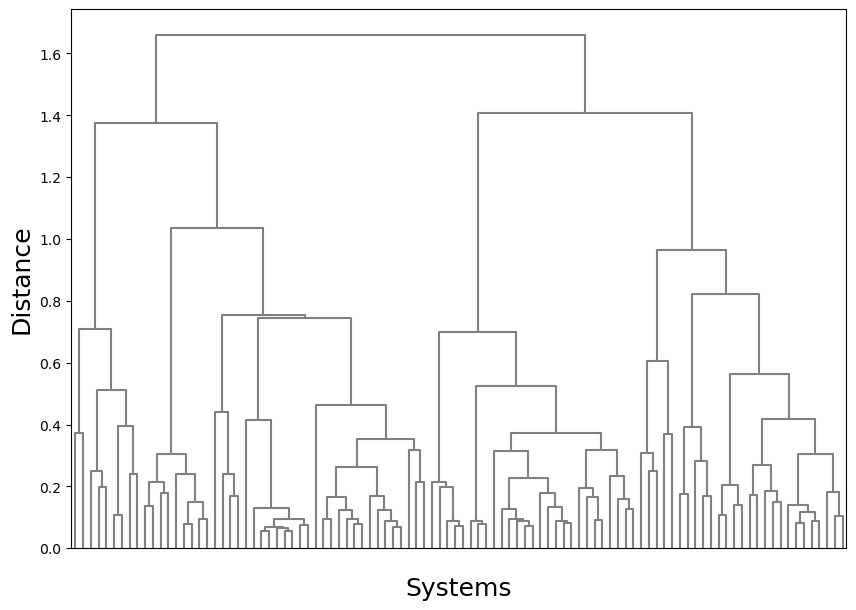

In [137]:
plot_dendrogram(df, save_file=True)

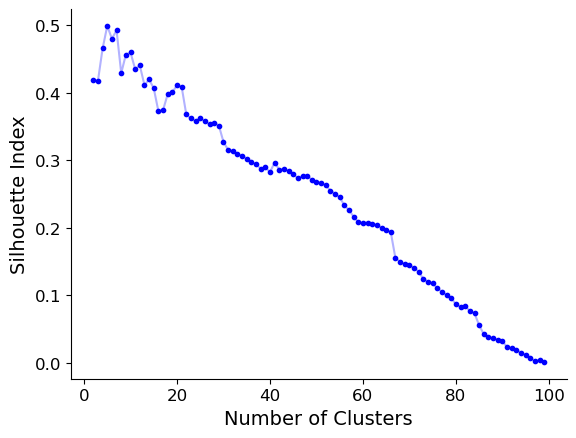

In [138]:
import matplotlib.pyplot as plt

# Your data
y_values = silhouette_score_agglomerative(df)  # Example data, replace with your own

# Specify the x-axis values
x_values = [i + 2 for i in range(len(y_values))]  # Example x-axis values, replace with your own

# Plotting
fig, ax = plt.subplots()
ax.plot(x_values, y_values, marker='.', color='b', linestyle='-', alpha=0.3)  # Set line alpha for transparency
ax.scatter(x_values, y_values, color='b', marker='.', label='Silhouette Score')  # Scatter plot for dots

# Increase text size
ax.set_xlabel('Number of Clusters', fontsize=14)  # Replace with your own x-axis label
ax.set_ylabel('Silhouette Index', fontsize=14)  # Replace with your own y-axis label
ax.tick_params(axis='both', which='major', labelsize=12)

# Remove gridlines
ax.grid(False)

# Remove upper and right borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Save the plot
plt.savefig('../../results/plot_silhouette_optimization.png', format='png', dpi=500)

# Show the plot
plt.show()


In [139]:
from scipy.cluster import hierarchy

# Assuming dist_matrix is your distance matrix
# Perform hierarchical clustering using the distance matrix
columns_to_filter = [str(i) for i in range(len(df))]
df_filter = df[columns_to_filter]
filled_df = df_filter.fillna(0)
matrix = filled_df.values
diagonal = np.diagonal(matrix)
matrix_final = matrix + matrix.transpose() 


np.fill_diagonal(matrix_final, 0)

#until here, we will have the positive distance matrix scaled to zero. 


# Below we get the linkage matrix, which will be used in many parts
upper_triangle_flat = matrix_final[np.triu_indices_from(matrix_final, k=1)]    
Z = hierarchy.linkage(upper_triangle_flat, method='complete') 

# print(upper_triangle_flat)
# print(Z)

In [140]:
n_clusters = 5  # Specify the number of clusters you want

# Get cluster assignments for each data point based on the number of clusters
clusters = hierarchy.fcluster(Z, n_clusters, criterion='maxclust')

df['cluster'] = clusters


In [141]:
index_4 = []
c_list = clusters.tolist()
for i in range(len(c_list)):
    if c_list[i]==4:
        index_4.append(i)
        

In [142]:
blank_df_clusters = create_blank_dataset_with_metadata(n_clusters)
records_to_be_added =[]
for i in range(1,n_clusters+1):
        records_to_be_added.append({'cluster num': i, 'p':0})
df_clusters = fill_dataset_with_records(blank_df_clusters, records_to_be_added)    


In [143]:
def proximal_mapping(a, gradient, t0_beta):
    # Proximal mapping using Kullback-Leibler divergence as the Bregman divergence


    a_tilde = a * np.exp(-t0_beta * gradient)
    a_tilde /= np.sum(a_tilde)
    return a_tilde

def opt_a(X, Y_list, b_list, t0, tol=1e-9, max_iter=1000):
    n = X.shape[0]
    N = len(Y_list)
    
    # Form all n x mi matrices Mi
    M_list = [np.linalg.norm(X[:, np.newaxis] - Y, axis=2) for Y in Y_list]
#     Initialize a_hat and a_tilde
    a_hat  = (np.ones(n) / n).reshape((n, 1))
    a_tilde = a_hat
    t = 3
    converged = False
    while not converged and t < max_iter:
        beta = (t + 1) / 2
        a = (1 - beta**-1) * a_hat + beta**-1 * a_tilde
        
        # Form subgradient alpha
        alpha_list = [calculate_OT_cost(a, b_list[i], 0.5,M_list[i], num_iterations=100, stop_theshold=10**-9)[1] for i in range(len(b_list))]
        alpha = np.mean(alpha_list, axis=0)
        # Update a_tilde using the proximal mapping
        t0_beta = t0 * beta
        a_tilde = proximal_mapping(a, alpha, t0_beta)
#         # Update a_hat
        a_hat = (1 - beta**-1) * a_hat + (beta**-1) * a_tilde
        
#         # Check convergence
        if np.linalg.norm(a_tilde - a_hat) < tol:
            converged = True
        
        t += 1
    return a_hat

def find_barycenter(X, Y_list, b_list, t0, theta, tol=1e-9, max_iter=1000):
    iter_num = 1
    while iter_num< max_iter:
        n = X.shape[0]
        N = len(Y_list)
        M_list = [np.linalg.norm(X[:, np.newaxis] - Y, axis=2) for Y in Y_list]
        
        
        a_update = opt_a(X, Y_list, b_list, t0, tol=1e-2, max_iter=30)

        
        T_list = [calculate_OT_cost(a_update, b_list[i], 0.2,M_list[i], num_iterations=50, stop_theshold=10**-2)[0] for i in range(len(b_list))]
        YT_list = [T_list[i] @ Y_list[i] for i in range(len(Y_list))]
        YT_ave = np.mean(YT_list, axis=0)
        X_old = X
        X = (1-theta) * X + theta * (np.diag((a_update**-1).T[0]) @ YT_ave)

        if np.linalg.norm(X - X_old) < tol:

            return X, a_update
        iter_num += 1 

    return X, a_update

def calculate_OT_cost(p, q, reg, cost_matrix, num_iterations, stop_theshold):
    Xi = np.exp(-cost_matrix / reg)
    v_n = np.ones((Xi.shape[1], 1))
    v_old = v_n
    for _ in range(num_iterations):
        v_n = q / (Xi.T @ (p / (Xi @ v_n)))
        if np.linalg.norm(v_n  - v_old)<stop_theshold:
            break
        v_old = v_n
    diag_u = np.diagflat((p / (Xi @ v_n)))
    diag_v = np.diagflat(v_n)
    OT_plan = diag_u @ Xi @ diag_v
    OT_cost = np.multiply(OT_plan, cost_matrix).sum()
    return OT_plan, p / (Xi @ v_n), v_n


In [144]:
def denormalize(matrix, min_values, max_values):
    return matrix * (max_values - min_values) + min_values




min_values_all = []
max_values_all = []
list_bary_X = []
list_bary_prob = []
list_inputs_cluster = []
list_p_cluster_new = []
list_sup_cluster_new = []
list_sup_cluster_real_new = []
for i in range(1, len(df_clusters)+1):

    df_test  = df[df['cluster']==i]
    list_column = df_test['data points real']
    
    list_sim_outputs_cluster = list_column.tolist()
    min_values_all.append(normalize_tuples(list_sim_outputs_cluster)[1])
    max_values_all.append(normalize_tuples(list_sim_outputs_cluster)[2])
    list_sim_outputs_cluster =  normalize_tuples(list_sim_outputs_cluster)[0]
    list_base_cluster = merge_list(list_sim_outputs_cluster)
    list_of_arrays = [np.array(inner_list) for inner_list in list_sim_outputs_cluster]
    X = np.random.rand(100, 5) # change p
    b_list = [(np.ones(len(list_sim_outputs_cluster[i])) / len(list_sim_outputs_cluster[i]) ).reshape((len(list_sim_outputs_cluster[i]), 1)) for i in range(len(list_sim_outputs_cluster))]
    t0 = 0.005
    theta = 0.005
    reg = 0.5
    bary_X, bary_a = find_barycenter(X, list_of_arrays, b_list, t0, theta, tol=1e-2*0.9, max_iter=400)
    list_bary_X.append(bary_X)
    list_bary_prob.append(bary_a)
    
    
    list_column_real = df_test['data points real']
    list_sim_outputs_cluster_real = list_column_real.tolist()
    list_base_cluster_real = merge_list(list_sim_outputs_cluster_real)
    
    list_column_input = df_test['input points']
    list_sim_inputs_cluster = list_column_input.tolist()
    
    cost_matrix_cluster = distance.cdist(list_base_cluster, list_base_cluster)
    density_list_cluster = density_calc_list(list_sim_outputs_cluster, list_base_cluster)
    list_sup_cluster_new.append(list_base_cluster)
    list_sup_cluster_real_new.append(list_base_cluster_real)
    list_inputs_cluster.append(list_sim_inputs_cluster)
    # here its real though nt mentioned 



In [145]:
matrices = list_bary_X
matrices = [denormalize(matrices[i], min_values_all[i], max_values_all[i]) for i in range(len(matrices))]

# Corresponding probability masses
prob_masses = list_bary_prob

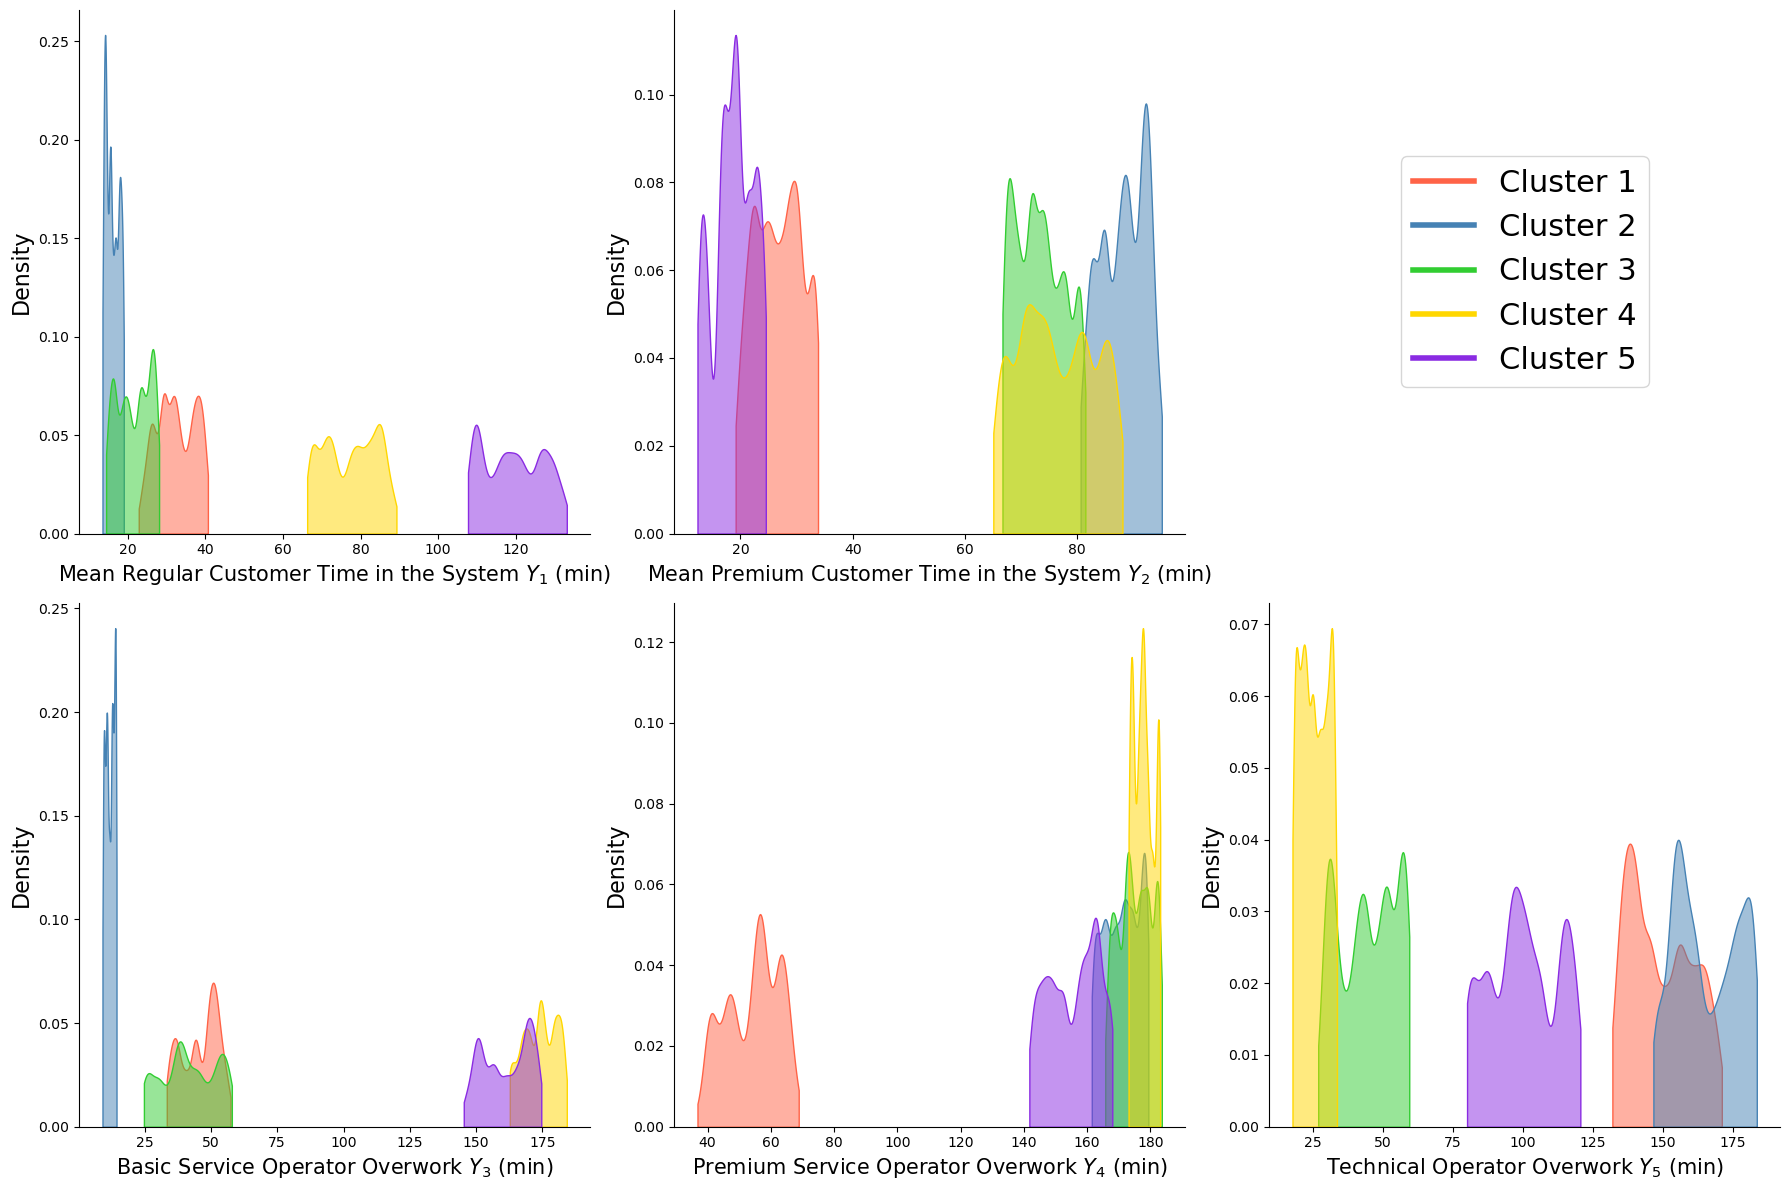

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

def plot_selected_distributions(data_points_list, prob_masses_list, selected_indices, x_labels):
    matrices = data_points_list
    prob_masses = prob_masses_list
    d = matrices[0].shape[1]

    # Define custom colors (you can change these to any valid color)
    custom_colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2', 'gray', "blue"]

    # Determine number of rows and columns for subplots
    nrows = 2
    ncols = 3  # Three columns as specified

    # Create subplots
    fig, axs = plt.subplots(nrows, ncols, figsize=(18, 12))

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    for dim in range(d):
        for idx in selected_indices:
            matrix = matrices[idx]
            points = matrix[:, dim]
            probs = prob_masses[idx]

            # Select custom color based on the index
            color = custom_colors[selected_indices.index(idx) % len(custom_colors)]
            label = f'Cluster {idx+1}'

            # Skip the last plot in the first row (legend position)
            plot_position = dim if dim < 2 else dim + 1

            # Plot KDE using seaborn with fill and transparency, and custom color
            sns.kdeplot(points, ax=axs[plot_position], fill=True, alpha=0.5, label=label, color=color, clip=(min(points), max(points)), bw_adjust=0.5)

            axs[plot_position].set_xlabel(x_labels[dim], fontsize = 15)
            axs[plot_position].set_ylabel('Density', fontsize=16)

            # Remove the upper and right border
            axs[plot_position].spines['top'].set_visible(False)
            axs[plot_position].spines['right'].set_visible(False)

    # Create a legend in the last plot space of the first row
    legend_ax = axs[2]  # The third plot space in the first row
    legend_ax.axis('off')
    handles = [
        Line2D([0], [0], color=custom_colors[i % len(custom_colors)], lw=4, label=f'Cluster {selected_indices[i] + 1}')
        for i in range(len(selected_indices))
    ]
    legend_ax.legend(handles=handles, loc='center', fontsize=22)

    plt.tight_layout()
    plt.savefig('../../results/plot_pdfs_custom_colors_cost.png', format='png', dpi=300)
    plt.show()

# Example usage:
# Assuming matrices and list_bary_prob are defined
x_labels = [
    r'Mean Regular Customer Time in the System $Y_1$ (min)',
    r'Mean Premium Customer Time in the System $Y_2$ (min)',
    r'Basic Service Operator Overwork $Y_3$ (min)',
    r'Premium Service Operator Overwork $Y_4$ (min)',
    r'Technical Operator Overwork $Y_5$ (min)'
]

plot_selected_distributions(matrices, list_bary_prob, [0, 1, 2, 3, 4], x_labels)
